In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
from scipy.optimize import minimize
import math as math
import scipy.stats as stats
from scipy.stats import anderson as ande
from scipy.stats import kstest
%matplotlib inline

Text(0, 0.5, 'maximum daily discharge (mm)')

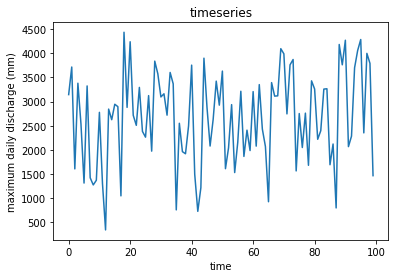

In [48]:
df = pd.read_csv('data1.csv')
plt.plot(df['data'])
plt.title('timeseries')
plt.xlabel('time')
plt.ylabel('maximum daily discharge (mm)')

In [40]:
# Gussain Parameter Estimation
mean_guass = df['data'].mean()
sd_guass = np.std(df['data'])

def guass(x):
    return ((1/(np.sqrt(2*np.pi)*sd_guass))*np.exp(-(0.5)*((x-mean_guass)/sd_guass)**2))

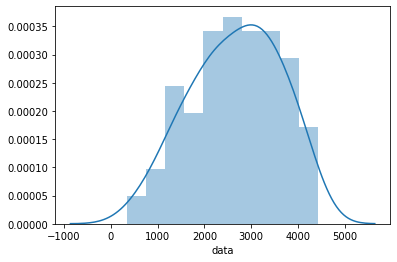

In [41]:
sns.distplot(df['data'],bins=10)

In [42]:
# chi squared distribution
mean = df['data'].mean()
sd = df['data'].std()
quater_percentile = df['data'].loc[4]
bin = (mean-quater_percentile)*2

cs_df = pd.DataFrame(index=[1,2,3,4,5,6,7,8],columns=['Interval_min','Interval_max','ni','pi','ei','ni_sq_by_ei'])
cs_df['Interval_min'].loc[5] = cs_df['Interval_max'].loc[4] = mean
cs_df['Interval_min'].loc[4] = cs_df['Interval_max'].loc[3] = mean - bin
cs_df['Interval_min'].loc[3] = cs_df['Interval_max'].loc[2] = mean - 2*bin
cs_df['Interval_min'].loc[2] = cs_df['Interval_max'].loc[1] = mean - 3*bin
cs_df['Interval_max'].loc[1] = mean - 3*bin
cs_df['Interval_min'].loc[1] = df['data'].min()
cs_df['Interval_min'].loc[6] = cs_df['Interval_max'].loc[5] = mean + bin
cs_df['Interval_min'].loc[7] = cs_df['Interval_max'].loc[6] = mean + 2*bin
cs_df['Interval_min'].loc[8] = cs_df['Interval_max'].loc[7] = mean + 3*bin
cs_df['Interval_min'].loc[8] = mean + 3*bin
cs_df['Interval_max'].loc[8] = df['data'].max()

for i in cs_df.index:
    cs_df['ni'][i] = df[(df['data']>cs_df['Interval_min'][i]) & (df['data']<cs_df['Interval_max'][i])]['data'].count()
#     cs_df['pi'][i] = quad(guass,np.NINF,cs_df['Interval_max'][i])[0] - quad(guass,np.NINF,cs_df['Interval_min'][i])[0]
    cs_df['pi'][i] = quad(guass,cs_df['Interval_min'][i],cs_df['Interval_max'][i])[0]
    cs_df['ei'][i] = df['data'].size * cs_df['pi'][i]
    cs_df['ni_sq_by_ei'] = (cs_df['ni']**2)/cs_df['ei']
    
print(cs_df)
    
test_stat_value = cs_df['ni_sq_by_ei'].sum() - df['data'].size

chi_df = pd.read_csv('chi_table.csv')

alpha = 0.05
dof = cs_df['Interval_min'].size-1

columns = np.array(chi_df.columns)
# print(columns)
for i in range(len(columns)):
    if columns[i] == str(alpha):
        alpha_col_index = i
        
critical_value = chi_df.iloc[dof-1,alpha_col_index]

print(critical_value , test_stat_value)

if critical_value<=test_stat_value:
    print("Reject Null Hypothesis")
else:
    print("Failed to reject Null hypothesis")

  Interval_min Interval_max  ni         pi       ei ni_sq_by_ei
1       346.63      1883.62  20   0.197372  19.7372     20.2663
2      1883.62      2145.08  11  0.0864747  8.64747     13.9925
3      2145.08      2406.53   7     0.1005    10.05     4.87563
4      2406.53      2667.99   8   0.108344  10.8344     5.90713
5      2667.99      2929.44  11   0.108344  10.8344     11.1682
6      2929.44       3190.9   8     0.1005    10.05     6.36817
7       3190.9      3452.35  13  0.0864747  8.64747     19.5433
8      3452.35      4433.67  20   0.173039  17.3039     23.1161
14.067 5.237376491367797
Failed to reject Null hypothesis


In [53]:
# Anderson Test
df['log_x'] = np.log(df['data'])

stats, crictical_value_anderson, significance_level = ande(df['log_x'],'norm')

for i in range(len(significance_level)):
    if significance_level[i] == alpha:
        significance_value_index = i
        break
        
print(stats, crictical_value_anderson, significance_level)
# if crictical_value_anderson[significance_value_index]<=

2.5725409264334047 [0.555 0.632 0.759 0.885 1.053] [15.  10.   5.   2.5  1. ]


In [44]:
# K-S test
ks_df = pd.DataFrame(columns=['x_i','xi_sorted','Sn_x','F(x)','|Fx-Sn(x)|'])
ks_df['x_i'] = df['data']
ks_df['xi_sorted'] = np.sort(ks_df['x_i'])
ks_df['Sn_x'] = (df.index+1)/ks_df['x_i'].size
for i in range(len(ks_df['x_i'])):
    ks_df['F(x)'][i] = quad(guass,np.NINF,ks_df['xi_sorted'][i])[0]
    
ks_df['|Fx-Sn(x)|'] = abs(ks_df['Sn_x'] - ks_df['F(x)'])

D = ks_df['|Fx-Sn(x)|'].max()
n = df['data'].size
alpha = 0.05
critical_value_ks = 1.36/math.sqrt(n)

if critical_value_ks>=D:
    print("We cannot reject null hypothesis")
else:
    print("Null Hypothesis rejected")

C:\Users\Piyush Patel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


We cannot reject null hypothesis


In [54]:
# To calculate p-value
ks_intepolating_test = [1.07/math.sqrt(n),1.22/math.sqrt(n),1.36/math.sqrt(n),1.63/math.sqrt(n)]
ks_intepolating_test = {'0.20':'1.07'}